# Conformalized Survival Regression

In this notebook we'll explore survival prediction in a classical setting, survival prediction under incomplete censoring times, and our proposed remedy for incomplete censoring times, using our novel technique.

First we need a baseline. In the classical case of Type I censoring, for every patient there is a triplet $(X,C,T)$, of which we have access to $(X,\tilde{T}=C\wedge T, T)$.
We'll use the same random generation process as Candes et. al.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os
import sys
%matplotlib inline

from sklearn.model_selection import train_test_split
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.util import Surv

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor

# Weighted Conformal

In [2]:
def non_conformity(y, y_hat):
    return np.append(y_hat - y, np.inf)

def estimate_weights(betas, C_hat, c_0):
    # Step 1: Find where C_hat > c_0
    greater_than_c0 = C_hat > c_0

    # Step 2: Find the index of the first True value in each row
    first_true_indices = (greater_than_c0.cumsum(axis=1) == 1).argmax(axis=1)

    # Step 3: Select the corresponding betas
    result = betas[first_true_indices]

    return 1.0/(1.0 - result)

def oracle_weights(betas, X_cal, lamb, c_0):
    exp_quantiles = np.array([- np.log(1-b)/lamb for b in betas]).reshape(1,-1)
    greater_than_c0 = (X_cal * exp_quantiles) > c_0
    first_true_indices = (greater_than_c0.cumsum(axis=1) == 1).argmax(axis=1)
    result = betas[first_true_indices]

    return 1.0/(1.0 - result)

def cfsurv_c0(X_train, X_test, C_train, T_train, T_test, c_0, alpha, delta_death=np.inf):
    # split the train data into training and calibration
    X_train, X_test, C_train, T_train, T_test = X_train.copy(), X_test.copy(), C_train.copy(), T_train.copy(), T_test.copy()
    T_tilde_train = Surv.from_arrays((T_train < C_train), np.minimum(T_train, C_train))
    C_train = Surv.from_arrays((C_train < T_train + delta_death), np.minimum(C_train, T_train + delta_death))
    T_tilde_train['time'] = np.minimum(T_tilde_train['time'], c_0)
    if len(X_train.shape) == 1 and len(X_test.shape) == 1:
        X_train = X_train.reshape(-1,1)
        X_test = X_test.reshape(-1,1)
    X_train, X_cal, C_train, C_cal, T_tilde_train, T_tilde_cal = train_test_split(X_train, C_train, T_tilde_train, train_size=X_train.shape[0]//2)
    
    # keep only data where C>=c_0
    T_tilde_cal, X_cal = T_tilde_cal[C_cal['time'] >= c_0].copy(), X_cal[C_cal['time'] >= c_0]
     
    # train a regression model on T: q_hat(x)
    T_est = GradientBoostingSurvivalAnalysis(loss="pinball", beta=1-alpha, learning_rate=1.0, max_depth=1, random_state=0)
    T_est.fit(X_train, T_tilde_train)
    
    # compute conformity score for each point in the calibration set
    T_cal_hat = T_est.predict(X_cal)
    scores = non_conformity(T_tilde_cal['time'], T_cal_hat)
    scores_test = non_conformity(T_test, T_est.predict(X_test))
    
    # estimate the weight for each point in the calibration set
    betas = np.array([beta/100.0 for beta in range(1, 100, 1)])
    C_est = [GradientBoostingSurvivalAnalysis(loss="pinball", beta=b, learning_rate=0.1, max_depth=1, random_state=0) for b in betas]
    C_hat_cal = []
    C_hat_test = []
    for est in C_est:
        est.fit(X_train, C_train)
        C_hat_cal.append(est.predict(X_cal))
        C_hat_test.append(est.predict(X_test))
    
    C_hat_cal = np.transpose(np.array(C_hat_cal))
    C_hat_test = np.transpose(np.array(C_hat_test))
    
    w_cal = estimate_weights(betas, C_hat_cal, c_0)

    # sort scores and weights
    sorted_indices = np.argsort(scores[:-1])
    scores = np.sort(scores)
    w_cal = w_cal[sorted_indices]
 
    # compute the weights for the test data
    w_test = estimate_weights(betas, C_hat_test, c_0)

    # compute propensity scores
    p_test = (w_test / (w_cal.sum() + w_test)).reshape(-1,1) # vector of length len(w_test)
    p_cal = w_cal.reshape(1,-1) / (w_cal.sum() + w_test.reshape(-1,1)) # size of (w_test, w_cal)
    p = np.concatenate([p_cal, p_test], axis=1)
    np.testing.assert_almost_equal(p[0].sum(),1, decimal=10) # f'propensity weights don\'t sum to 1, sum: {p[0].sum()}'

    # compute weighted quantiles for each test point
    cumulative_weights = np.cumsum(p, axis=1)
    np.testing.assert_almost_equal(p[-1].sum(), 1, decimal=10) # 'wrong cumsum axis'
    quantile_indices = np.argmax(cumulative_weights >= (1-alpha), axis=1)
    quantile_values = scores[quantile_indices]

    # compute LPB
    lpb = np.minimum(T_est.predict(X_test) - quantile_values, c_0)
    emp_coverage = (lpb <= np.minimum(T_test, c_0)) # coverage for min(T,c_0)
    emp_coverage = emp_coverage.sum()/len(emp_coverage)
    emp_coverage_T = (lpb <= T_test) # coverage for T

    return lpb, emp_coverage, emp_coverage_T, scores, scores_test, w_test

## $c_0$ Choice

In this section, we choose the optimal $c_0$ value that gives the closest coverage to $1-\alpha$, to use in the following experiments.

In [3]:
n_samples = 10000
X_uni = np.random.uniform(low=0.0, high=4.0, size=n_samples)
X_uni.sort()
C_uni = np.random.exponential(10, size=n_samples) * X_uni
mu_uni = 2 + 0.37 * np.sqrt(X_uni)
sd_uni_homo = 1.5
sd_uni_hetero = 1 + X_uni/5

T_uni_homo = np.exp(np.random.normal(loc=mu_uni, scale=sd_uni_homo, size=n_samples))
T_tilde_uni_homo = Surv.from_arrays((T_uni_homo < C_uni), np.minimum(T_uni_homo, C_uni))
T_uni_hetero = np.exp(np.random.normal(loc=mu_uni, scale=sd_uni_hetero, size=n_samples))
T_tilde_uni_hetero = Surv.from_arrays((T_uni_hetero < C_uni), np.minimum(T_uni_hetero, C_uni))
T_tilde_uni_hetero = np.minimum(T_uni_hetero, C_uni)

In [4]:
alpha = 0.1
betas = np.array([beta/10.0 for beta in range(1, 10, 1)])
X_uni_homo_train, X_uni_homo_test, C_uni_homo_train, C_uni_homo_test, T_uni_homo_train, T_uni_homo_test = train_test_split(X_uni, C_uni, T_uni_homo)
X_uni_het_train, X_uni_het_test, C_uni_het_train, C_uni_het_test, T_uni_het_train, T_uni_het_test = train_test_split(X_uni, C_uni, T_uni_hetero)

In [5]:
c_0_vals = np.array(np.logspace(0,2,10))
coverage_homo = []
for c_0 in c_0_vals:
    coverage_c_0 = 0
    for i in range(5):
        lpb, emp_coverage, emp_coverage_T, scores, scores_test, w_test = cfsurv_c0(X_uni_homo_train, X_uni_homo_test, C_uni_homo_train, T_uni_homo_train, T_uni_homo_test, c_0, 0.1)
        coverage_c_0 += emp_coverage
    coverage_homo.append(coverage_c_0/5)

coverage_het = []
for c_0 in c_0_vals:
    coverage_c_0 = 0
    for i in range(5):
        lpb, emp_coverage, emp_coverage_T, scores, scores_test, w_test = cfsurv_c0(X_uni_het_train, X_uni_het_test, C_uni_het_train, T_uni_het_train, T_uni_het_test, c_0, 0.1)
        coverage_c_0 += emp_coverage
    coverage_het.append(coverage_c_0/5)

In [6]:
coverage_het

[0.9814399999999999,
 0.94224,
 0.9136,
 0.9072000000000001,
 0.90624,
 0.8927200000000001,
 0.91008,
 0.9368000000000001,
 0.94816,
 0.97112]

In [7]:
c_0_opt_homo = c_0_vals[coverage_homo.index(min(coverage_homo, key=lambda x: abs(x - alpha)))]
c_0_opt_het = c_0_vals[coverage_het.index(min(coverage_het, key=lambda x: abs(x - alpha)))]
print(f'c_0_opt_homo: {c_0_opt_homo}')
print(f'c_0_opt_het: {c_0_opt_het}')

c_0_opt_homo: 12.91549665014884
c_0_opt_het: 12.91549665014884


# Adversarial Survival Boosting

In [9]:
def train(X, C, T, w, beta_t, beta_c, n_stages = 100):
    # Make sure X is the right shape
    X = X.copy().reshape(-1,1).astype(np.float32)
    C = C.copy()
    T = T.copy()
    C["time"] = np.log(C["time"])
    T["time"] = np.log(T["time"])

    # Initialize the models
    C_estimator = GradientBoostingSurvivalAnalysis(loss="pinball", beta=beta_c, learning_rate=0.1, max_depth=1, random_state=0, warm_start=True, n_estimators=n_stages)
    T_estimator = GradientBoostingSurvivalAnalysis(loss="pinball", beta=beta_t, learning_rate=0.1, max_depth=1, random_state=0, warm_start=True, n_estimators=n_stages)
    discriminator = GradientBoostingClassifier(n_estimators=5)
    C_estimator.n_features_in_ = X.shape[1]
    T_estimator.n_features_in_ = X.shape[1]
    C_estimator._check_params()
    T_estimator._check_params()
    C_estimator._init_state()
    T_estimator._init_state()
    C_loss = C_estimator._loss
    C_estimator.init_.fit(X, (C['event'],C['time']))
    T_loss = T_estimator._loss
    T_estimator.init_.fit(X, (T['event'],T['time']))
    C_pred = C_loss.get_init_raw_predictions(X, C_estimator.init_)
    T_pred = T_loss.get_init_raw_predictions(X, T_estimator.init_)
    sample_weight = np.ones(X.shape[0], dtype=np.float32)
    sample_mask = np.ones((X.shape[0],), dtype=bool)
    residuals_discriminator = 0

    # Perform iterative, stage-wise fitting
    for i in range(0,n_stages):
        for k in range(C_loss.K):
            C_pred_copy = C_pred.copy()
            T_pred_copy = T_pred.copy()
            C_residual = C_loss.negative_gradient(C, C_pred_copy, k=k, sample_weight=sample_weight) -  w * residuals_discriminator

            # induce regression tree on residuals
            C_tree = DecisionTreeRegressor(
                criterion=C_estimator.criterion,
                splitter="best",
                max_depth=C_estimator.max_depth,
                min_samples_split=C_estimator.min_samples_split,
                min_samples_leaf=C_estimator.min_samples_leaf,
                min_weight_fraction_leaf=C_estimator.min_weight_fraction_leaf,
                min_impurity_decrease=C_estimator.min_impurity_decrease,
                max_features=C_estimator.max_features,
                max_leaf_nodes=C_estimator.max_leaf_nodes,
                random_state=C_estimator.random_state,
                ccp_alpha=C_estimator.ccp_alpha,
            )

            C_tree.fit(X, C_residual, sample_weight=sample_weight, check_input=False)

            # add tree to ensemble
            C_estimator.estimators_[i, k] = C_tree

            # update tree leaves
            C_loss.update_terminal_regions(
                C_tree.tree_,
                X,
                C,
                C_residual,
                C_pred,
                sample_weight,
                sample_mask,
                learning_rate=C_estimator.learning_rate,
                k=k,
            )

            T_residual = T_loss.negative_gradient(T, T_pred_copy, k=k, sample_weight=sample_weight) -  w * residuals_discriminator

            # induce regression tree on residuals
            T_tree = DecisionTreeRegressor(
                criterion=T_estimator.criterion,
                splitter="best",
                max_depth=T_estimator.max_depth,
                min_samples_split=T_estimator.min_samples_split,
                min_samples_leaf=T_estimator.min_samples_leaf,
                min_weight_fraction_leaf=T_estimator.min_weight_fraction_leaf,
                min_impurity_decrease=T_estimator.min_impurity_decrease,
                max_features=T_estimator.max_features,
                max_leaf_nodes=T_estimator.max_leaf_nodes,
                random_state=T_estimator.random_state,
                ccp_alpha=T_estimator.ccp_alpha,
            )

            T_tree.fit(X, T_residual, sample_weight=sample_weight, check_input=False)

            # add tree to ensemble
            T_estimator.estimators_[i, k] = T_tree

            # update tree leaves
            T_loss.update_terminal_regions(
                T_tree.tree_,
                X,
                T,
                T_residual,
                T_pred,
                sample_weight,
                sample_mask,
                learning_rate=T_estimator.learning_rate,
                k=k,
            )

        C_star = C_pred.copy()
        C_star[C['event']] = C['time'][C['event']].reshape(-1,1)
        T_star = T_pred.copy()
        T_star[T['event']] = T['time'][T['event']].reshape(-1,1)

        X_disc = np.concatenate([np.column_stack((X, C_star, T_star)), np.column_stack((X, C_pred, T_pred))], axis=0)
        Y_disc = np.concatenate([np.ones(X.shape[0]), np.zeros(X.shape[0])], axis=0)

        discriminator.fit(X_disc, Y_disc)
        residuals_discriminator = discriminator._loss.negative_gradient(Y_disc, discriminator.predict_proba(X_disc)[:,1])
        residuals_discriminator = - residuals_discriminator[X.shape[0]:] + residuals_discriminator[:X.shape[0]]

    return C_estimator, T_estimator

In [10]:
def censor(T,C, death_delta):
    T_tilde = Surv.from_arrays((T < C), np.minimum(T, C))
    C_tilde = Surv.from_arrays((C < T + death_delta), np.minimum(C, T + death_delta))
    return T_tilde, C_tilde

def list_predict(T_est_list, X_test):
    return np.mean(np.array([est.predict(X_test) for est in T_est_list]), axis=0)

def cfsurv_c0_adv(X_train, X_test, C_train, T_train, T_test, c_0, alpha, delta_death=np.inf):
    # split the train data into training and calibration
    X_train, X_test, C_train, T_train, T_test = X_train.copy(), X_test.copy(), C_train.copy(), T_train.copy(), T_test.copy()
    T_tilde_train = Surv.from_arrays((T_train < C_train), np.minimum(T_train, C_train))
    C_train = Surv.from_arrays((C_train < T_train + delta_death), np.minimum(C_train, T_train + delta_death))
    T_tilde_train['time'] = np.minimum(T_tilde_train['time'], c_0)
    if len(X_train.shape) == 1 and len(X_test.shape) == 1:
        X_train = X_train.reshape(-1,1)
        X_test = X_test.reshape(-1,1)
    X_train, X_cal, C_train, C_cal, T_tilde_train, T_tilde_cal = train_test_split(X_train, C_train, T_tilde_train, train_size=X_train.shape[0]//2)
    
    # keep only data where C>=c_0
    T_tilde_cal, X_cal = T_tilde_cal[C_cal['time'] >= c_0].copy(), X_cal[C_cal['time'] >= c_0]
     
    # train advaserialy
    betas = np.array([beta/100.0 for beta in range(1, 100, 1)])
    ests = [train(X=X_train, C=C_train, T=T_tilde_train, w=1, beta_t=1-alpha, beta_c=beta, n_stages=10) for beta in betas]
    C_ests, T_ests = zip(*ests)

    # compute conformity score for each point in the calibration set
    T_cal_hat = list_predict(T_ests, X_cal)
    scores = non_conformity(T_tilde_cal['time'], T_cal_hat)
    T_test_hat = list_predict(T_ests, X_test)
    scores_test = non_conformity(T_test, T_test_hat)
    
    # estimate the weight for each point in the calibration set
    C_hat_cal = []
    C_hat_test = []
    for est in C_ests:
        C_hat_cal.append(est.predict(X_cal))
        C_hat_test.append(est.predict(X_test))
    
    C_hat_cal = np.transpose(np.array(C_hat_cal))
    C_hat_test = np.transpose(np.array(C_hat_test))
    
    w_cal = estimate_weights(betas, C_hat_cal, c_0)

    # sort scores and weights
    sorted_indices = np.argsort(scores[:-1])
    scores = np.sort(scores)
    w_cal = w_cal[sorted_indices]
 
    # compute the weights for the test data
    w_test = estimate_weights(betas, C_hat_test, c_0)

    # compute propensity scores
    p_test = (w_test / (w_cal.sum() + w_test)).reshape(-1,1) # vector of length len(w_test)
    p_cal = w_cal.reshape(1,-1) / (w_cal.sum() + w_test.reshape(-1,1)) # size of (w_test, w_cal)
    p = np.concatenate([p_cal, p_test], axis=1)
    np.testing.assert_almost_equal(p[0].sum(),1, decimal=10) # f'propensity weights don\'t sum to 1, sum: {p[0].sum()}'

    # compute weighted quantiles for each test point
    cumulative_weights = np.cumsum(p, axis=1)
    np.testing.assert_almost_equal(p[-1].sum(), 1, decimal=10) # 'wrong cumsum axis'
    quantile_indices = np.argmax(cumulative_weights >= (1-alpha), axis=1)
    quantile_values = scores[quantile_indices]

    # compute LPB
    lpb = np.minimum(list_predict(T_ests, X_test) - quantile_values, c_0)
    emp_coverage = (lpb <= np.minimum(T_test, c_0)) # coverage for min(T,c_0)
    emp_coverage = emp_coverage.sum()/len(emp_coverage)
    emp_coverage_T = (lpb <= T_test) # coverage for T

    return lpb, emp_coverage, emp_coverage_T, scores, scores_test, w_test

Generate new Data for experiments:

In [12]:
n_samples = 10000
X_uni = np.random.uniform(low=0.0, high=4.0, size=n_samples)
X_uni.sort()
X_multi = np.random.uniform(low=-1.0, high=1.0, size=(n_samples, 100))
C_uni = np.random.exponential(10, size=n_samples) * X_uni
C_multi = np.random.exponential(10, size=n_samples) * (X_multi[:,0] + 1)
mu_uni = 2 + 0.37 * np.sqrt(X_uni)
sd_uni_homo = 1.5
sd_uni_hetero = 1 + X_uni/5

T_uni_homo = np.exp(np.random.normal(loc=mu_uni, scale=sd_uni_homo, size=n_samples))
T_tilde_uni_homo = Surv.from_arrays((T_uni_homo < C_uni), np.minimum(T_uni_homo, C_uni))
T_uni_hetero = np.exp(np.random.normal(loc=mu_uni, scale=sd_uni_hetero, size=n_samples))
T_tilde_uni_hetero = Surv.from_arrays((T_uni_hetero < C_uni), np.minimum(T_uni_hetero, C_uni))
T_tilde_uni_hetero = np.minimum(T_uni_hetero, C_uni)

mu_multi = np.log(2) + 1 + 0.55 * (X_multi[:,0]**2 + X_multi[:,2] * X_multi[:,4])
sd_multi_homo = 1
sd_multi_hetero = np.abs(X_multi[:,9]) + 1

T_multi_homo = np.exp(np.random.normal(loc=mu_multi, scale=sd_multi_homo, size=n_samples))
T_tilde_multi_homo = Surv.from_arrays((T_multi_homo < C_multi), np.minimum(T_multi_homo, C_multi))
T_multi_hetero = np.exp(np.random.normal(loc=mu_multi, scale=sd_multi_hetero, size=n_samples))
T_tilde_multi_hetero = Surv.from_arrays((T_multi_hetero < C_multi), np.minimum(T_multi_hetero, C_multi))

In [13]:
X_uni_homo_train, X_uni_homo_test, C_uni_homo_train, C_uni_homo_test, T_uni_homo_train, T_uni_homo_test = train_test_split(X_uni, C_uni, T_uni_homo)
X_uni_het_train, X_uni_het_test, C_uni_het_train, C_uni_het_test, T_uni_het_train, T_uni_het_test = train_test_split(X_uni, C_uni, T_uni_hetero)
X_multi_homo_train, X_multi_homo_test, C_multi_homo_train, C_multi_homo_test, T_multi_homo_train, T_multi_homo_test = train_test_split(X_multi, C_multi, T_multi_homo)
X_multi_het_train, X_multi_het_test, C_multi_het_train, C_multi_het_test, T_multi_het_train, T_multi_het_test = train_test_split(X_multi, C_multi, T_multi_hetero)

## Comparing Adversarial Training to Vanilla

In [14]:
import warnings

c_0_opt_het = 9

coverage_uni_homo = {}
coverage_uni_homo_adv = {}
coverage_uni_het = {}
coverage_uni_het_adv = {}
coverage_T_uni_homo = {}
coverage_T_uni_het = {}
scores_homo = {}
scores_homo_adv = {}
scores_het = {}
scores_het_adv = {}
weights_homo = {}
weights_homo_adv = {}
weights_het = {}
weights_het_adv = {}

death_delta = np.append(np.array(np.logspace(0.5,2,10)), np.inf)
repeat_range = range(10)

warnings.filterwarnings("ignore")

for d in death_delta:
    coverage_uni_homo[d] = []
    coverage_uni_homo_adv[d] = []
    coverage_uni_het[d] = []
    coverage_uni_het_adv[d] = []

    scores_homo[d] = []
    scores_homo_adv[d] = []
    scores_het[d] = []
    scores_het_adv[d] = []

    weights_homo[d] = []
    weights_homo_adv[d] = []
    weights_het[d] = []
    weights_het_adv[d] = []

    for i in repeat_range:
        lpb_homo, emp_coverage_homo, emp_coverage_T_homo, _, scores_homo_test, w_test_homo = cfsurv_c0(X_uni_homo_train, X_uni_homo_test, C_uni_homo_train, T_uni_homo_train, T_uni_homo_test, c_0_opt_homo, 0.1, d)
        lpb_homo_adv, emp_coverage_homo_adv, emp_coverage_T_homo_adv, _, scores_homo_test_adv, w_test_homo_adv = cfsurv_c0_adv(X_uni_homo_train, X_uni_homo_test, C_uni_homo_train, T_uni_homo_train, T_uni_homo_test, c_0_opt_homo, 0.1, d)
        lpb_het, emp_coverage_het, emp_coverage_T_het, _, scores_het_test, w_test_het = cfsurv_c0(X_uni_het_train, X_uni_het_test, C_uni_het_train, T_uni_het_train, T_uni_het_test, c_0_opt_het, 0.1, d)
        lpb_het, emp_coverage_het_adv, emp_coverage_T_het, _, scores_het_test_adv, w_test_het_adv = cfsurv_c0_adv(X_uni_het_train, X_uni_het_test, C_uni_het_train, T_uni_het_train, T_uni_het_test, c_0_opt_het, 0.1, d)
        
        coverage_uni_homo[d].append(emp_coverage_homo)
        coverage_uni_homo_adv[d].append(emp_coverage_homo_adv)
        coverage_uni_het[d].append(emp_coverage_het)
        coverage_uni_het_adv[d].append(emp_coverage_het_adv)

        scores_homo[d].append(scores_homo_test)
        scores_homo_adv[d].append(scores_homo_test_adv)
        scores_het[d].append(scores_het_test)
        scores_het_adv[d].append(scores_het_test_adv)

        weights_homo[d].append(w_test_homo)
        weights_homo_adv[d].append(w_test_homo_adv)
        weights_het[d].append(w_test_het)
        weights_het_adv[d].append(w_test_het_adv)

warnings.filterwarnings("default")

## Figures

Coverage as a Function of D-T

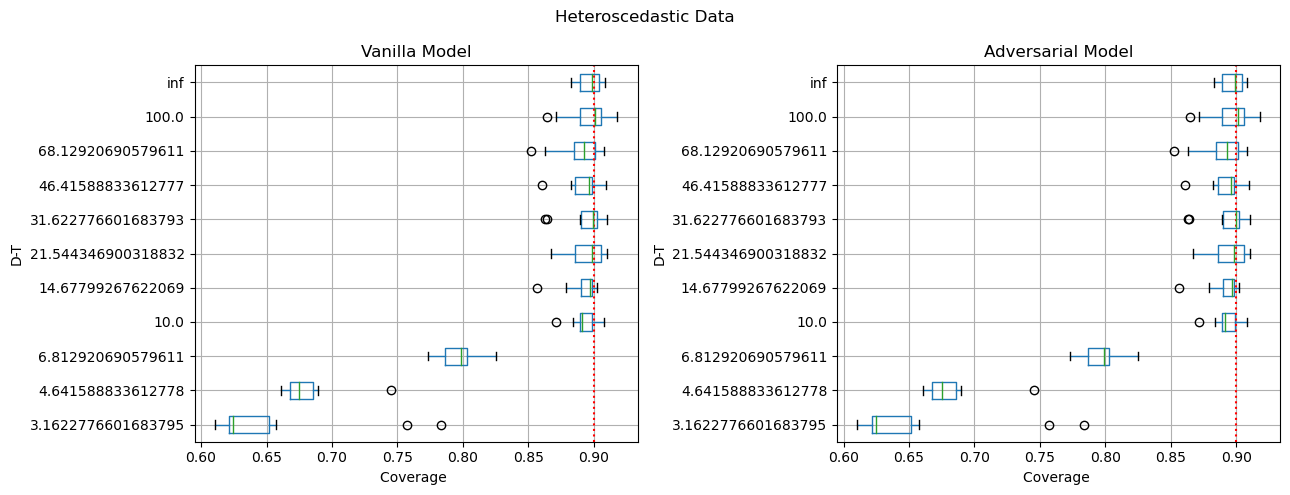

In [70]:
# Convert the dictionary to a pandas DataFrame
df1 = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in coverage_uni_het.items() ]))
df1 = df.reindex(sorted(df.columns, key=float), axis=1)
df2 = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in coverage_uni_het_adv.items() ]))
df2 = df.reindex(sorted(df.columns, key=float), axis=1)

# Create a figure and axis with 2 columns
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))

# Create the boxplot on the first axis
bp1 = df1.boxplot(vert=False, ax=axs[0])
axs[0].set_xlabel('Coverage ')
axs[0].set_ylabel('D-T')
axs[0].axvline(x=0.9, color='red', linestyle='dotted')
axs[0].set_title("Vanilla Model")

# Create the boxplot on the second axis
bp2 = df2.boxplot(vert=False, ax=axs[1])
axs[1].set_xlabel('Coverage ')
axs[1].set_ylabel('D-T')
axs[1].axvline(x=0.9, color='red', linestyle='dotted')
axs[1].set_title("Adversarial Model")

# Display the plot
plt.suptitle("Heteroscedastic Data")
plt.tight_layout()
plt.show()

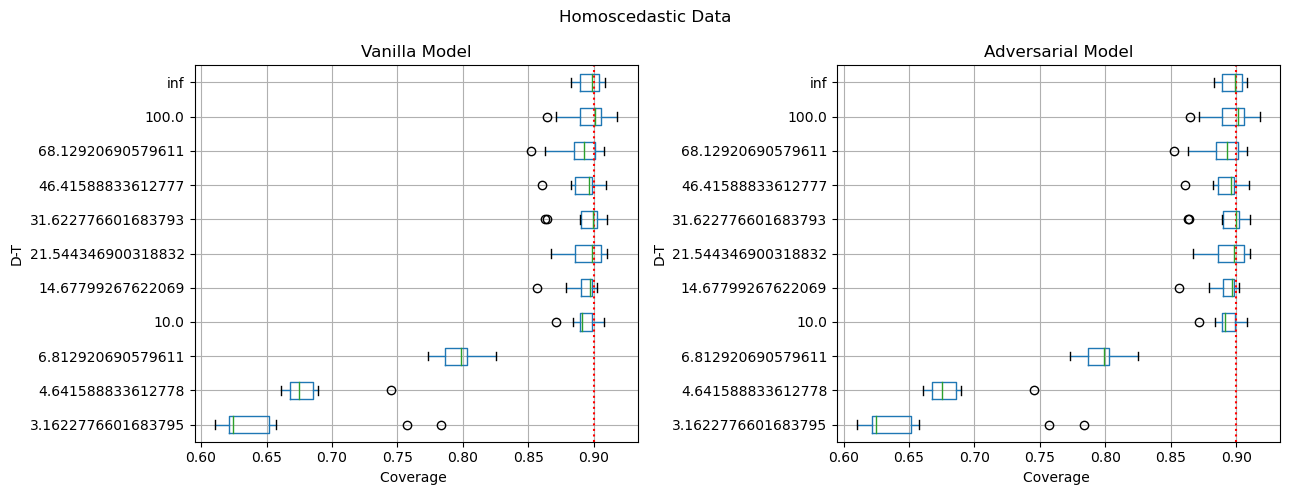

In [69]:
# Convert the dictionary to a pandas DataFrame
df1 = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in coverage_uni_homo.items() ]))
df1 = df.reindex(sorted(df.columns, key=float), axis=1)
df2 = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in coverage_uni_homo_adv.items() ]))
df2 = df.reindex(sorted(df.columns, key=float), axis=1)

# Create a figure and axis with 2 columns
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))

# Create the boxplot on the first axis
bp1 = df1.boxplot(vert=False, ax=axs[0])
axs[0].set_xlabel('Coverage ')
axs[0].set_ylabel('D-T')
axs[0].axvline(x=0.9, color='red', linestyle='dotted')
axs[0].set_title("Vanilla Model")

# Create the boxplot on the second axis
bp2 = df2.boxplot(vert=False, ax=axs[1])
axs[1].set_xlabel('Coverage ')
axs[1].set_ylabel('D-T')
axs[1].axvline(x=0.9, color='red', linestyle='dotted')
axs[1].set_title("Adversarial Model")

# Display the plot
plt.suptitle("Homoscedastic Data")
plt.tight_layout()
plt.show()

Comparing The Weights

In [42]:
print(f'Oracle weights variance: {np.var(weights_oracle)}')

Oracle weights variance: 97.64437403107104


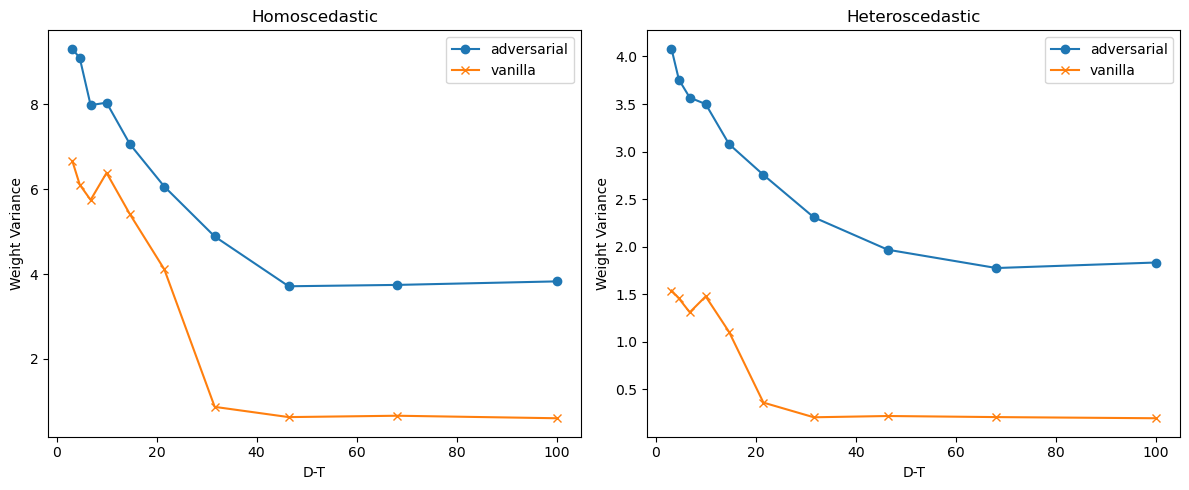

In [49]:
import numpy as np
import matplotlib.pyplot as plt

def plot_variances(weights_dict1, weights_dict2, ax, title):
    variances_dict1 = {d: np.var(weights) for d, weights in weights_dict1.items() }
    variances_dict2 = {d: np.var(weights) for d, weights in weights_dict2.items() }
    
    d1, var1 = zip(*variances_dict1.items())
    d2, var2 = zip(*variances_dict2.items())
    
    ax.plot(d1, var1, label='adversarial', marker='o')
    ax.plot(d2, var2, label='vanilla', marker='x')
    ax.set_xlabel('D-T')
    ax.set_ylabel('Weight Variance')
    ax.legend()
    ax.set_title(title)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_variances(weights_homo, weights_homo_adv, axes[0], 'Homoscedastic')
plot_variances(weights_het, weights_het_adv, axes[1], 'Heteroscedastic')

plt.tight_layout()
# fig.suptitle("Weight Variance as a Function of D-T")
plt.show()


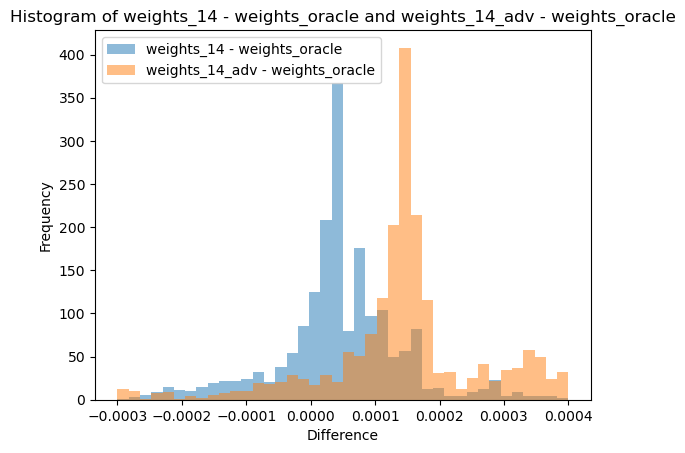

In [50]:
weights_14 = weights_homo[death_delta[4]][-1]
weights_14 = weights_14/np.sum(weights_14)
weights_14_adv = weights_homo_adv[death_delta[4]][-1]
weights_14_adv = weights_14_adv/np.sum(weights_14_adv)
weights_oracle = weights_oracle/np.sum(weights_oracle)

# Calculate the differences between the lists
diff_test = [a - b for a, b in zip(weights_14, weights_oracle)]
diff_test_adv = [a - b for a, b in zip(weights_14_adv, weights_oracle)]

# Create the histogram
plt.hist(diff_test, bins=40, alpha=0.5, label='weights_14 - weights_oracle',  range=(-0.0003, 0.0004))
plt.hist(diff_test_adv, bins=40, alpha=0.5, label='weights_14_adv - weights_oracle',  range=(-0.0003, 0.0004))

# Add labels and title
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.title('Histogram of weights_14 - weights_oracle and weights_14_adv - weights_oracle')

# Show the legend
plt.legend()

# Display the histogram
plt.show()

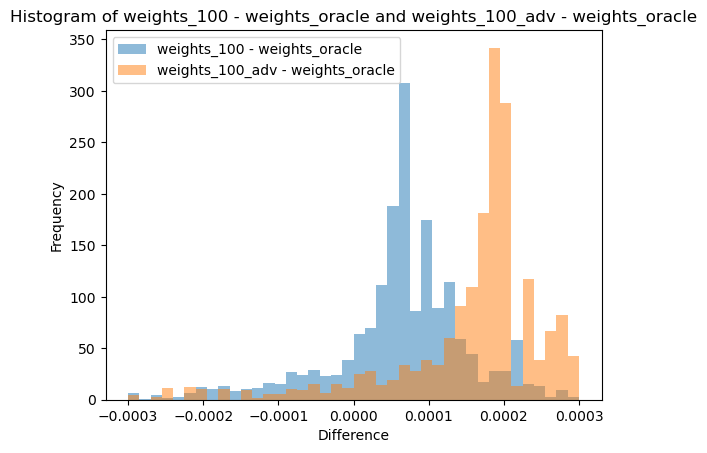

In [51]:
weights_100 = weights_homo[death_delta[-2]][-1]
weights_100 = weights_100/np.sum(weights_100)
weights_100_adv = weights_homo_adv[death_delta[-2]][-1]
weights_100_adv = weights_100_adv/np.sum(weights_100_adv)

# Calculate the differences between the lists
diff_test = [a - b for a, b in zip(weights_100, weights_oracle)]
diff_test_adv = [a - b for a, b in zip(weights_100_adv, weights_oracle)]

# Create the histogram
plt.hist(diff_test, bins=40, alpha=0.5, label='weights_100 - weights_oracle',  range=(-0.0003, 0.0003))
plt.hist(diff_test_adv, bins=40, alpha=0.5, label='weights_100_adv - weights_oracle',  range=(-0.0003, 0.0003))

# Add labels and title
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.title('Histogram of weights_100 - weights_oracle and weights_100_adv - weights_oracle')

# Show the legend
plt.legend()

#  Display the histogram
plt.show()

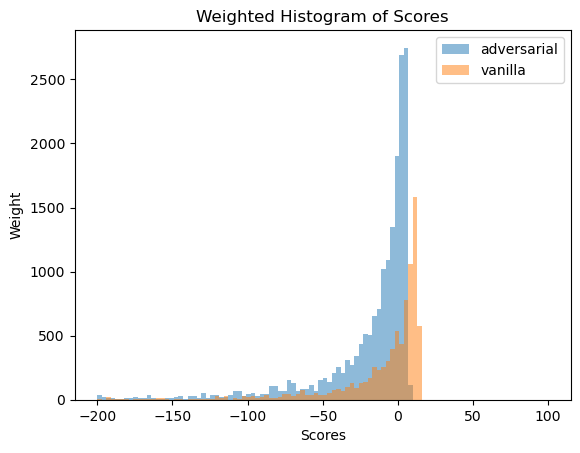

In [72]:
plt.hist(scores_homo_adv[death_delta[4]][-1][:-1], bins=100, weights=weights_homo_adv[death_delta[4]][-1], range=(-200, 100), alpha=0.5, label='adversarial')
plt.hist(scores_homo[death_delta[4]][-1][:-1], bins=100, weights=weights_homo[death_delta[4]][-1], range=(-200, 100), alpha=0.5, label='vanilla')

# Add labels and title
plt.xlabel('Scores')
plt.ylabel('Weight')
plt.title('Weighted Histogram of Scores')
plt.legend()

# Show the plot
plt.show()


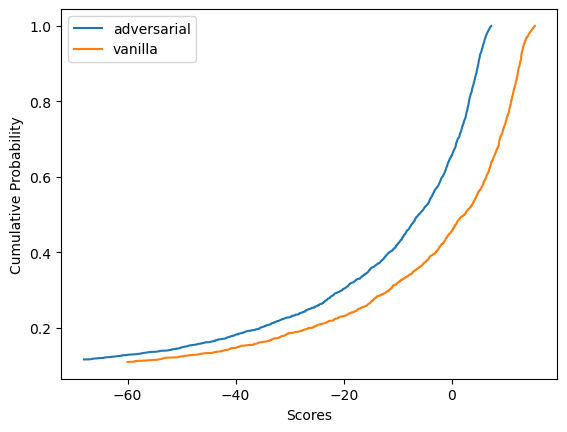

In [75]:
# Sort the data
sorted_data = np.sort(scores_homo[death_delta[4]][-1][:-1])
sorted_data_adv = np.sort(scores_homo_adv[death_delta[4]][-1][:-1])

# Multiply cumulative probabilities by the weights
sorted_indices = np.argsort(scores_homo[death_delta[4]][-1][:-1])
weighted_probs = weights_homo[death_delta[4]][-1][sorted_indices] / np.sum(weights_homo[death_delta[4]][-1])
sorted_indices_adv = np.argsort(scores_homo_adv[death_delta[4]][-1][:-1])
weighted_probs_adv = weights_homo_adv[death_delta[4]][-1][sorted_indices_adv] / np.sum(weights_homo_adv[death_delta[4]][-1])

# Plot the empirical CDF
plt.plot(sorted_data_adv[300:], weighted_probs_adv.cumsum()[300:], label='adversarial')
plt.plot(sorted_data[300:], weighted_probs.cumsum()[300:], label='vanilla')
plt.xlabel('Scores')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.show()